Neuroon evaluation using metric functions
-----------------------------------------

Here we will compare neuroon staging against psg staging assumed to be ground truth. The neuroon hipnogram will be shifted by the offset identified in the eeg signals cross correlation (-160 seconds). A main confusion matrix will display the distribution of staging predicitions of neuroon compared to the staging of psg. Confusion matrixes will also be created for classification performance for each stage. They represent the percentage overlap between neuroon and psg staging.

Coonfusion matrix scheme :


| PSG / Neuroon 	| Yes            	| No             	|
|---------------	|----------------	|----------------	|
| Yes           	| True Positive  	| False Negative  	|
| No            	| False Positive 	| True Negative 	|



Permutation test on accuracy score will be used to assess whether observed confusion matrix could have been produced by chance.

Accuracy is defined as:

$$\frac{\sum{TruePositive} + \sum{TrueNegative}} {\sum{TotalPopulation}}$$

i.e. accuracy is a summary statistic of confusion matrix: sum of matrix diagonal divided by its total sum

Cohen's kappa [2] will be used to determine if the simmilarity between neuroon and psg was obtained by chance or randomly. 



Cohen's kappa is the percent agreement between two raters corrected for possibility of agreement by chance.
Cohen's kappa is defined as [1]:


$$\kappa = \frac{P(a) - P(e)}{1-P(e)}$$

* P(a) is the observed agreement
* P(e) is the chance agreement

$$ P(e) = \frac{\frac{cm^1 * rm^1}{n} + \frac{cm^2 * rm^2}{n}}{n} $$

where:
* cm1 represents column 1 marginal
* cm2 represents column 2 marginal
* rm1 represents row 1 marginal
* rm2 represents row 2 marginal

n represents the total number of observations

<img src="images/cohen_tresholds.png" ,width=400, height=400> 


[1] Mchugh, M. L. (2012). Interrater reliability : the kappa statistic. Biochemia Medica., 22(3), 276–282.

[2] Cohen, J. (1960). A coefficient of agreement for nominal scales. Educational and Psychosocial Measurement, 20, 37-46.


Waking accuracy
---------------
Neuroon claims to be able to increase effectivness of sleep by waking the subject up in a specific sleep stage. This approach agrees with the research on sleep: "One of the most critical factors is the sleep stage prior to awakening.
Abrupt awakening during a slow wave sleep (SWS) episode produces more sleep inertia than awakening
in stage 1 or 2, REM sleep being intermediate." [3] We will therefore produce a special confusion matrix describing neuroon abillity to judge when to and when not to wake the subject up. 

[3] Tassi, P., & Muzet, A. (2000). Sleep inertia. Sleep Medicine Reviews, 4(4), 341–353.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict 
import parse_hipnogram as ph
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import sklearn.metrics as metrics
from matplotlib.dates import  DateFormatter
import seaborn as sns
from datetime import timedelta
plt.rcParams['figure.figsize'] = (9.0, 5.0)
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

from statsmodels.stats.inter_rater import cohens_kappa, to_table
labels = ['rem','N1', 'N2', 'N3','wake']

stage_to_num = {'W':5, 'R':1, 'N1':2 , 'N2':3, 'N3':4 }
dummy_dict = {'stage_1': 'rem', 'stage_2' : 'N1', 'stage_3' : 'N2', 'stage_4': 'N3', 'stage_5':'wake'}
stage_color_dict = {'N1' : 'royalblue', 'N2' :'forestgreen', 'N3' : 'coral', 'rem' : 'plum', 'wake' : 'lightgray' }

original_accuracy_dict = {}

loading


In [2]:
def prepare_hipnograms(night):
    # load hipnograms, resample them and select their common time window

    psg_hipnogram = ph.parse_psg_stages(night = night).resample('1s').fillna(method = 'ffill')

    # Shift the neuroon hipnogram by the offset identified in eeg signals cross correaltion
    neuroon_hipnogram = ph.parse_neuroon_stages(night = night, time_shift = -160)
    neuroon_hipnogram = neuroon_hipnogram.resample('1s').fillna(method = 'ffill')

    # Trim hipnograms to the common time window so the confusion matrix calculations are accurate
    neuroon_hipnogram = neuroon_hipnogram.between_time('23:00', '06:00')

    psg_hipnogram = psg_hipnogram.between_time('23:00', '06:00')
    
    return neuroon_hipnogram, psg_hipnogram 

In [3]:
def plot_main_confusion_matrix(night):
    
    neuroon_hipnogram, psg_hipnogram = prepare_hipnograms(night)

    # Create a list of staging predictions
    true_stage = psg_hipnogram['stage_num'].as_matrix()
    predicted_stage = neuroon_hipnogram['stage_num'].astype(int).as_matrix()

    fig, axes = plt.subplots()
    fig.suptitle('all stages confusion matrix')

    # Compute the confusion matrix. The values in the cells are minutes (hipnograms are resampled to 1 hz resolution, thus dividing by 60 produces minutes)
    cm = confusion_matrix(true_stage, predicted_stage) / 60.0

    sns.heatmap(cm, annot = True, xticklabels =labels,  yticklabels = labels, fmt = '.1f', ax = axes, vmax = 90)

    axes.set_ylabel('psg')
    axes.set_xlabel('neuroon')

    # Compute precision, recall and f1-score for the multilabel classification from neuroon
    report = metrics.classification_report(true_stage,predicted_stage, target_names = labels )
    print(report)

    # Compute accuracy, give it this name to use after permutation
    original_accuracy = metrics.accuracy_score(true_stage,predicted_stage,)
    print('accuracy: %.2f'%original_accuracy)
    original_accuracy_dict[night] = original_accuracy 
    waking_performance(cm)

In [4]:
def waking_performance(cm):
    
    rem = 0
    n1 = 1
    n2 = 2
    n3 = 3
    wake =4
    
    # Correct waking: Sum of TP for shallow sleep stages, i.e. both neuroon and psg said its time to wake up
    correct_waking = cm[n1, n1].sum() + cm[n2, n2].sum()  + cm[wake, wake].sum()
    
    # Missed waking: Sum where psg said it was shallow sleep but neuroon said it was deep, i.e. psg said its time to wake up, neuroon said its better to sleep 
    missed_waking = cm[[n1, n2 , wake], rem].sum() +   cm[[n1, n2 , wake], n3].sum()
    
    # Sum of false negatives for deep sleep, i.e. psg said its better to sleep, neuroon said its time to wake up
    incorrect_waking = cm[rem, [n1, n2, wake]].sum() + cm[n3, [n1, n2, wake]].sum()
    
    # Both psg and neuroon let the subject sleep
    correct_sleeping = cm[rem, rem].sum() + cm[n3, n3].sum()
    
    # combine waking decisions into a confusion matrix
    waking_matrix = np.array([[correct_waking, missed_waking],[incorrect_waking, correct_sleeping]])
    
    fig, axes = plt.subplots()
    sns.heatmap(waking_matrix, annot = True, xticklabels =['yes', 'no'],  yticklabels = ['yes', 'no'], fmt = '.1f', ax = axes)
    
    axes.set_ylabel('psg')    
    axes.set_xlabel('neuroon')
    fig.suptitle('Stage allows easy wake up?')

parse_hipnogram.py:151: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  psg_stages = psg_stages.append(psg_copy).sort('order')
/home/alxd/Sketchbook/neuroon/peer-review-project/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
parse_hipnogram.py:76: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  neuroon_stages = neuroon_stages.sort(columns = 'timestamp')
/home/alxd/Sketchbook/neuroon/peer-review-project/venv/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted

             precision    recall  f1-score   support

        rem       0.70      0.60      0.64      4033
         N1       0.00      0.00      0.00      2190
         N2       0.57      0.91      0.70     10050
         N3       0.62      0.50      0.56      6690
       wake       0.28      0.01      0.03      2238

avg / total       0.53      0.60      0.53     25201

accuracy: 0.60


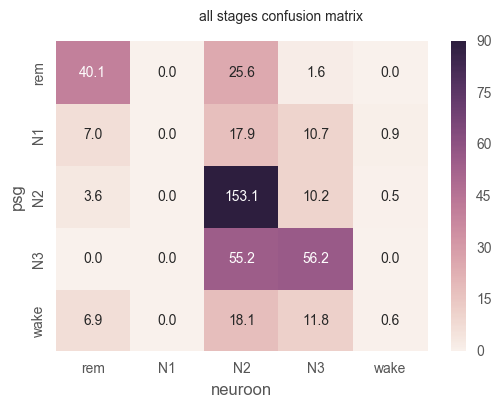

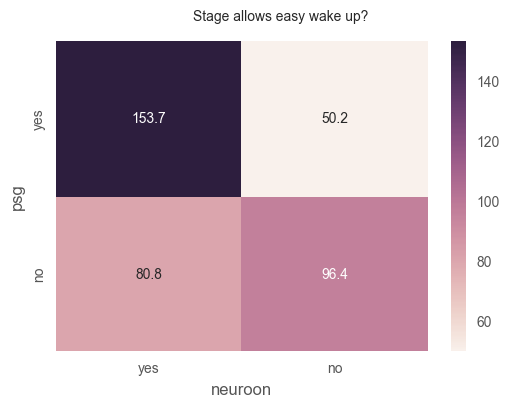

In [5]:
plot_main_confusion_matrix(1)

             precision    recall  f1-score   support

        rem       0.80      0.85      0.82      6030
         N1       0.00      0.00      0.00      1181
         N2       0.70      0.70      0.70     10640
         N3       0.64      0.76      0.70      6750
       wake       0.31      0.14      0.19       600

avg / total       0.67      0.70      0.68     25201

accuracy: 0.70


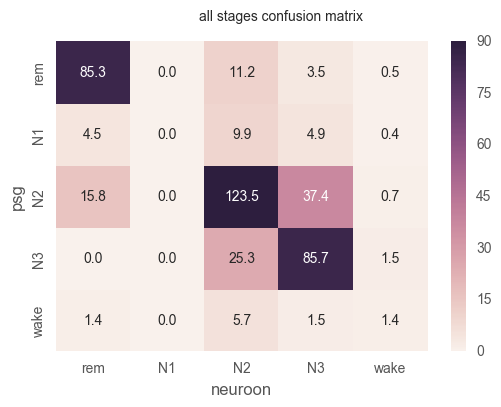

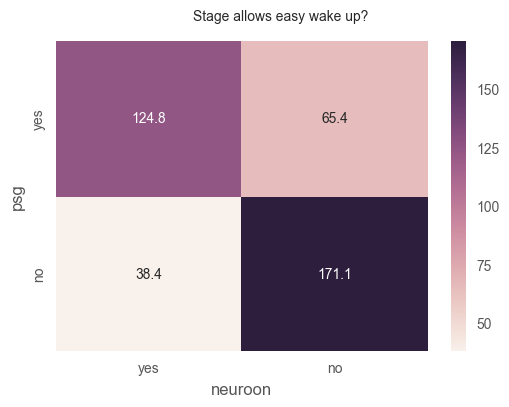

In [6]:
plot_main_confusion_matrix(2)

In [7]:
def binarize_stages(hipnogram):
    return pd.get_dummies(hipnogram, prefix = 'stage')


In [8]:

def confusion_matrix_separate(night):
    
    neuroon_hipnogram, psg_hipnogram = prepare_hipnograms(night)

    
    # make a confusion matrix for each stage binarized (stage = 1, all_other = 0)
    # TODO, neuroon stages saved as float, change to int upstream
    neuroon_binarized = binarize_stages(neuroon_hipnogram['stage_num'].astype(int))
    psg_binarized = binarize_stages(psg_hipnogram['stage_num'])
    
    fig_p, axes_p = plt.subplots(nrows = 2,ncols = 2, figsize = (8,8))
    fig_n, axes_n = plt.subplots(nrows = 2,ncols = 2, figsize = (8,8))
    
    fig_p.suptitle('Confusion matrixes normalized to psg (column sum)')
    fig_n.suptitle('Confusion matrixes normalized to neuroon (row sum)')
    
    roc_fig, roc_axes = plt.subplots(figsize = (6,6))
    roc_fig.suptitle('ROC')
        
    for neuroon_stage, axp, axn in zip(neuroon_binarized, axes_p.reshape(-1), axes_n.reshape(-1)):
        
        stage_predicted = neuroon_binarized[neuroon_stage].as_matrix()
        stage_true = psg_binarized[neuroon_stage].as_matrix()

        # Compute the confusion matrix [[tp, fn], [fp, tn]]
        cm = confusion_matrix(stage_true, stage_predicted)
        
        
        # Confusion matrix is organized accroding to dummy coding, so the upper right cell [0,0] will have true negatives (psg = 0 and neuroon = 0)
        # This is not accroding to the conventional way of viualizing the matrix, so we'll rotate it
        cm = np.rot90(cm, 2)
        
        # Compute the cohen kappa for the confusion matrix
        table = cohens_kappa(cm)

        # Normalize the confusion matrix by row (i.e by the total length for stage detected by psg)
        cm_normalized_p = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Normalize the confusion matrix by row (i.e by the total length for stage detected by neuroon)
        cm_normalized_n = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        
        # Make a plot of scores in the roc space, i.e. fp vs tp
        roc_axes.plot(cm_normalized_p[1,0], cm_normalized_p[0,0], marker= 'o', color = stage_color_dict[dummy_dict[neuroon_stage]], label = dummy_dict[neuroon_stage])
        
        #Plot the whole confusion matrix normalized to show percentages
        sns.heatmap(cm_normalized_p, annot = True, xticklabels = ['yes','no'],\
                    yticklabels = ['yes','no'],fmt = '.2f', ax = axp, linewidths=.5,\
                   vmin = 0.0, vmax = 1.0)
        sns.heatmap(cm_normalized_n, annot = True, xticklabels = ['yes','no'],\
                    yticklabels = ['yes','no'],fmt = '.2f', ax = axn, linewidths=.5,\
                   vmin = 0.0, vmax = 1.0)
        
        axp.set_title(dummy_dict[neuroon_stage] + '\n Cohen\'s kappa: %.2f / %.2f'%(table.kappa, table.kappa_max))
        axn.set_title(dummy_dict[neuroon_stage] + '\n Cohen\'s kappa: %.2f / %.2f'%(table.kappa, table.kappa_max))

    axes_p[0,0].set_ylabel('psg')
    axes_p[1,0].set_ylabel('psg')
    axes_p[1,0].set_xlabel('neuroon')
    axes_p[1,1].set_xlabel('neuroon')

        #print(dummy_dict[neuroon_stage])
        # uncomment to see other results, confidence intervals 
        # print('max kappa %.2f'%table.kappa_max)
        #print(table)
        
    roc_axes.plot([0,1], [0,1], color = 'black', linestyle = '--', alpha = 0.5)
    roc_axes.set_xlabel('false_positive')
    roc_axes.set_ylabel('true_positive')
    roc_axes.legend(loc = 'best')
    
    fig_p.tight_layout()
    fig_n.tight_layout()


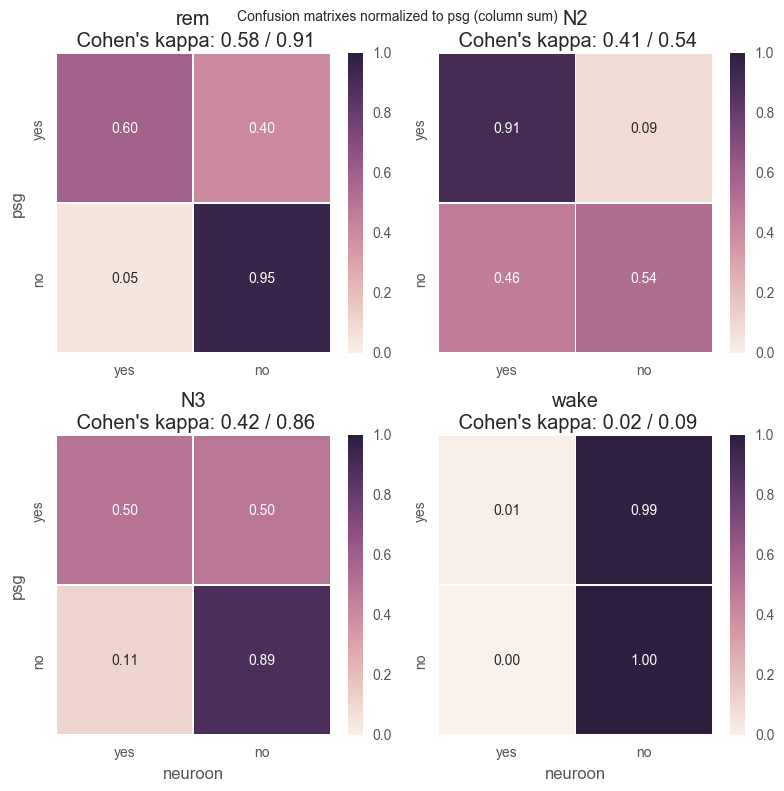

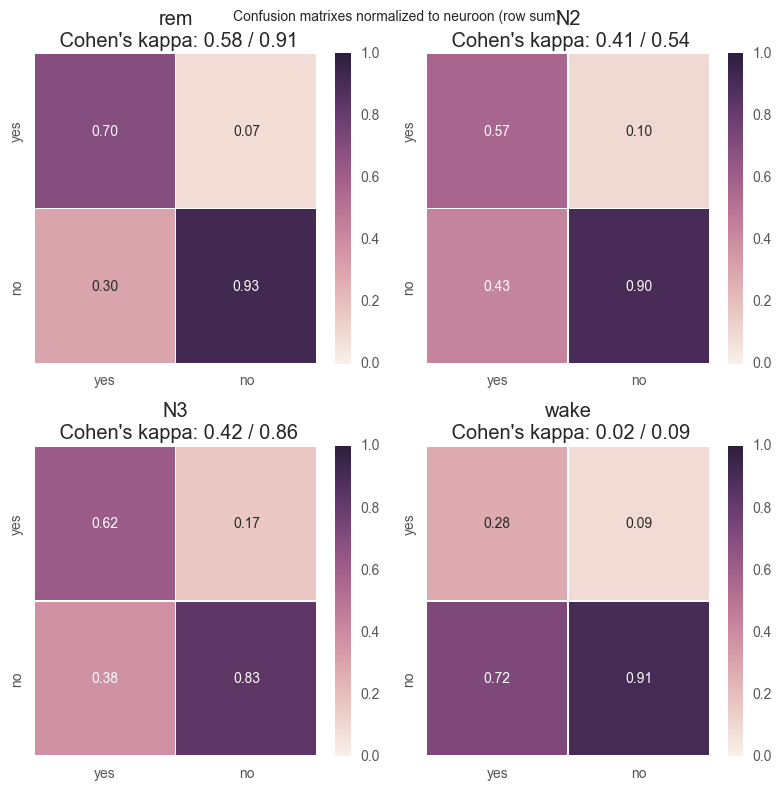

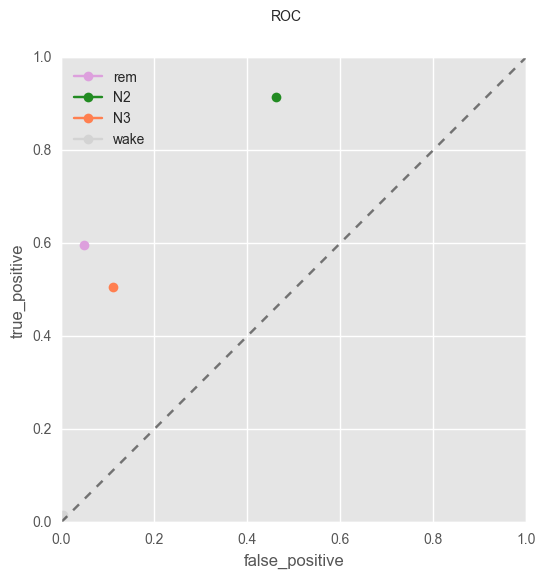

In [9]:
confusion_matrix_separate(1)

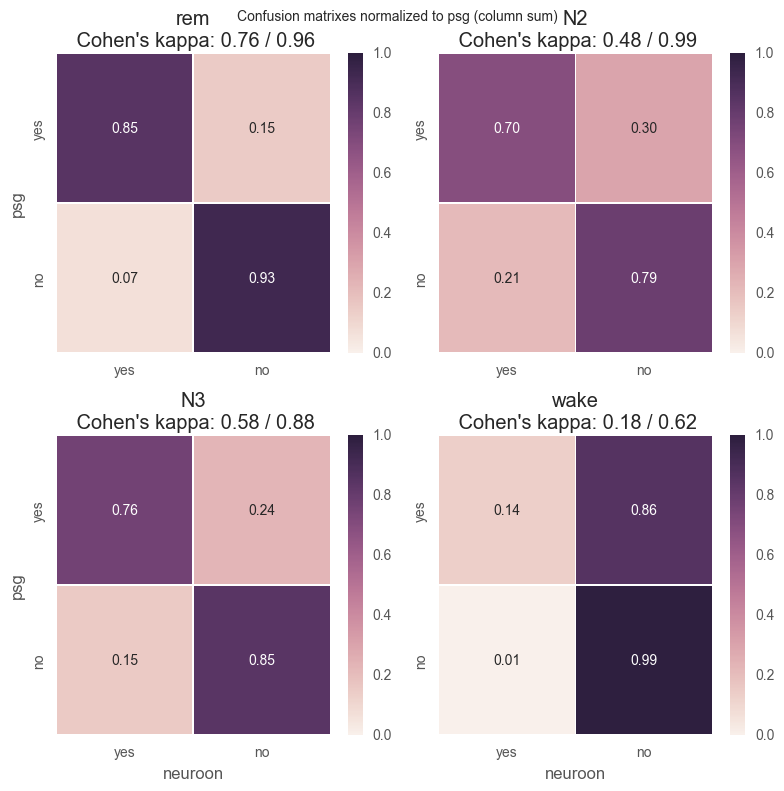

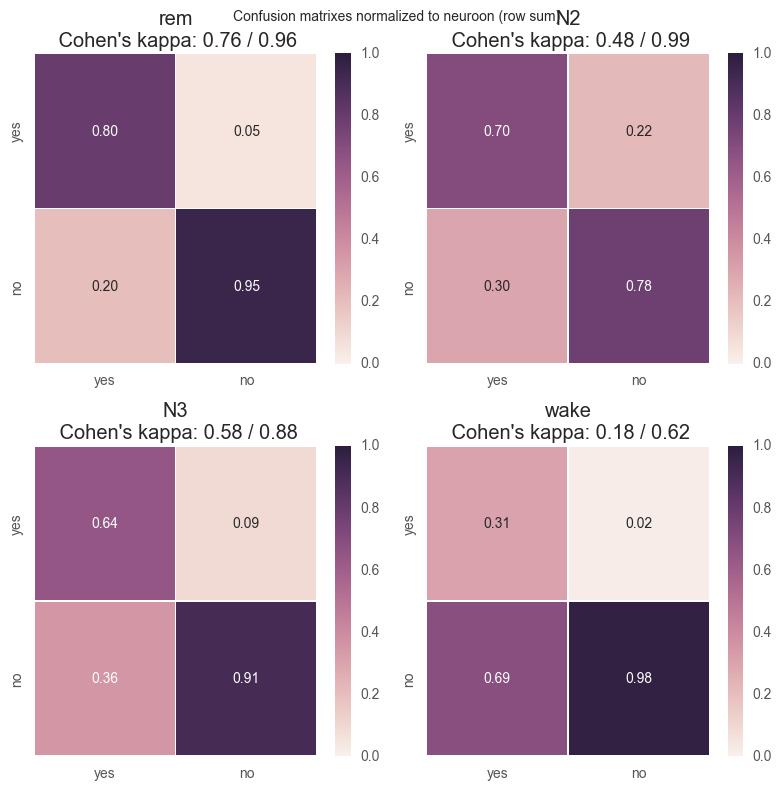

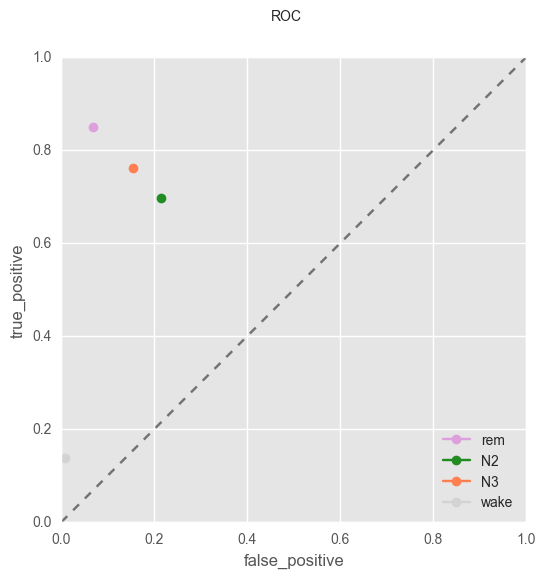

In [10]:
confusion_matrix_separate(2)

In [11]:
# Permutation test by shuffling (without replacement) the stage labels neuroon assigned in original 30sec freq staging
def permute_neuroon_staging(night):
    # load hipnograms, resample them and select their common time window
    neuroon_hipnogram = ph.parse_neuroon_stages(time_shift = -160, night = night, permute = True).resample('1s').fillna(method = 'ffill')
    psg_hipnogram = ph.parse_psg_stages(night = night).resample('1s').fillna(method = 'ffill')

    # Get the start and end of the time window covered by both hipnograms
    start = neuroon_hipnogram.index.searchsorted(psg_hipnogram.index.get_values()[0])
    end = psg_hipnogram.index.searchsorted(neuroon_hipnogram.index.get_values()[-1])

    # Trim hipnograms to the common time window so the confusion matrix calculations are accurate
    # +1 and -1 because events got cut in half, resulting in ends without starts
    neuroon_hipnogram = neuroon_hipnogram.ix[start ::]
    # +1 because upper bound is not included
    psg_hipnogram = psg_hipnogram.ix[0:end +1]
    
    true_stage = psg_hipnogram['stage_num'].as_matrix()
    predicted_stage = neuroon_hipnogram['stage_num'].astype(int).as_matrix()
    
    # Measure accuracy score 
    acc_score = metrics.accuracy_score(true_stage,predicted_stage)
    
    return acc_score



In [12]:
def run_perm(night):

    # run permutation test
    num_perm = 100
    permuted_accuracy = []
    for i in range(num_perm):
        permuted_accuracy.append(permute_neuroon_staging(night))

    permuted_accuracy = np.array(permuted_accuracy)
    
    fig, axes = plt.subplots(figsize = (8,6))
    axes.axvline(original_accuracy_dict[night], color = 'k', linestyle = '--', label = 'original score')
    sns.distplot(permuted_accuracy, ax = axes, label = 'permutation scores')

    axes.set_title('accuracy permutation test')
    axes.set_ylabel('number of occurences')
    axes.set_xlabel('accuracy score')
    axes.legend()


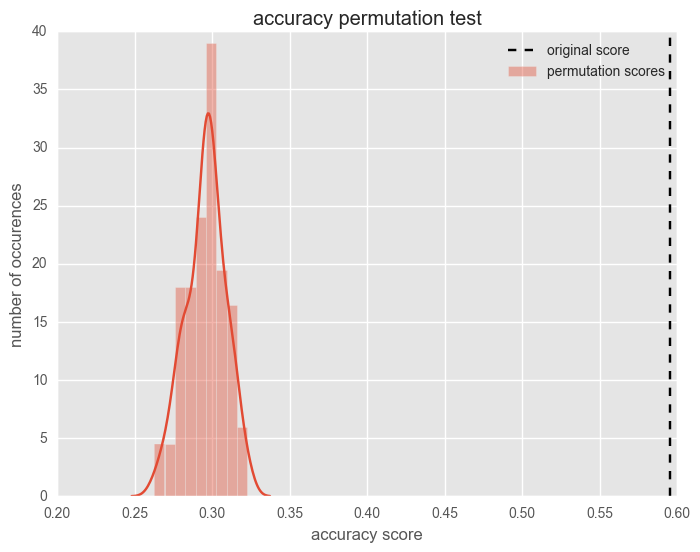

In [13]:
run_perm(1)

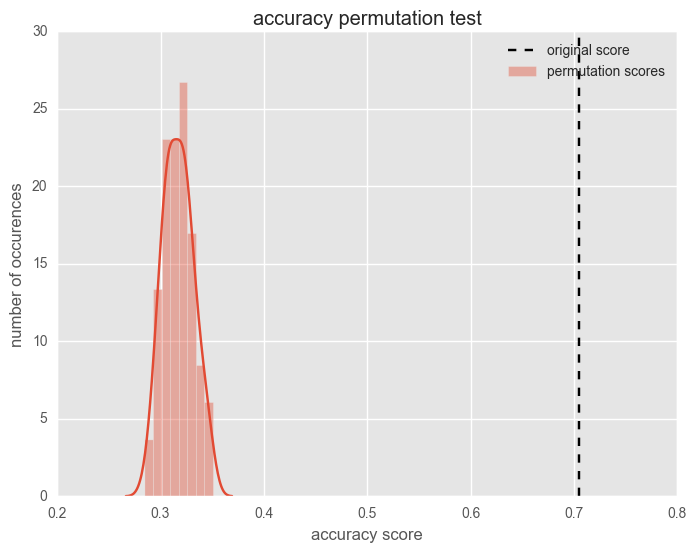

In [14]:
run_perm(2)